# Crypto Market Surveillance Notebook

Synthetic crypto exchange telemetry paired with baseline surveillance + ML scoring. Each section explains how to interpret the plots and tables so you can move from macro indicators to individual cases.

## How to use this notebook
1. **Load or regenerate data** &mdash; first code cell auto-runs the engine if CSV artifacts are missing. Re-run it after changing code so fresh artifacts + ML scores are produced.
2. **Review the dataset snapshot** to confirm row counts (unexpected drops usually mean upstream issues).
3. **Scan structural views** &mdash; float-share leaders, shared-IP clusters, price curves, aggressor volume, order imbalance, cross-venue spreads.
4. **Check ML anomaly leaderboard** for outlier accounts that may evade simple heuristics.
5. **Triaging alerts** &mdash; use the case-management panel to filter, set statuses, and note findings.
6. Iterate: jump between plots and cases; when suspicious clusters align across sections, escalate for deeper investigation.

In [1]:
from __future__ import annotations

import sys
from pathlib import Path

import pandas as pd

ROOT = Path('..')
SRC = ROOT / 'src'
if str(SRC) not in sys.path:
    sys.path.append(str(SRC))

from market_surveillance.engine import SurveillanceEngine

DATA_DIR = ROOT / 'data'
DATA_DIR.mkdir(exist_ok=True)

def load_data():
    accounts_path = DATA_DIR / 'accounts.csv'
    trades_path = DATA_DIR / 'trades.csv'
    orders_path = DATA_DIR / 'orders.csv'
    alerts_path = DATA_DIR / 'alerts_snapshot.csv'
    positions_path = DATA_DIR / 'positions.csv'
    ml_scores_path = DATA_DIR / 'ml_scores.csv'
    resources = [accounts_path, trades_path, orders_path, alerts_path, positions_path]
    if not all(p.exists() for p in resources):
        engine = SurveillanceEngine(output_dir=DATA_DIR)
        result = engine.run()
        accounts = result.data.accounts
        trades = result.data.trades
        orders = result.data.orders
        positions = result.data.positions
        alerts = pd.DataFrame([alert.as_record() for alert in result.alerts])
        ml_scores = result.ml_scores
    else:
        accounts = pd.read_csv(accounts_path, parse_dates=['created_at'])
        trades = pd.read_csv(trades_path, parse_dates=['timestamp'])
        orders = pd.read_csv(orders_path, parse_dates=['timestamp', 'completion_ts'])
        alerts = pd.read_csv(alerts_path, parse_dates=['event_time'])
        positions = pd.read_csv(positions_path)
        ml_scores = pd.read_csv(ml_scores_path) if ml_scores_path.exists() else pd.DataFrame()
    return accounts, trades, orders, alerts, positions, ml_scores

accounts, trades, orders, alerts, positions, ml_scores = load_data()
alerts = alerts.reset_index(drop=True)
alerts['alert_id'] = alerts.index
accounts.head(), trades.head(), positions.head(), alerts.head(), ml_scores.head()

(  account_id region  account_type risk_tier                created_at  \
 0   ACC-0000     US        retail      high 2025-07-18 00:00:00+00:00   
 1   ACC-0001     US        retail       low 2025-08-25 00:00:00+00:00   
 2   ACC-0002     EU  market_maker       low 2025-08-18 00:00:00+00:00   
 3   ACC-0003     US        retail      high 2025-07-24 00:00:00+00:00   
 4   ACC-0004   APAC        retail       low 2025-08-31 00:00:00+00:00   
 
    baseline_volume device_id        ip_subnet behavior_cluster  is_flagged  
 0     59156.733096   FP-0387  10.220.160.0/24           BC-083        True  
 1     90120.116709   FP-0350  10.123.202.0/24           BC-096       False  
 2     73761.512873   FP-0227  10.242.130.0/24           BC-088       False  
 3     78941.717359   SHARED-  172.26.204.0/24           BC-SH-        True  
 4    166768.090951   SHARED-  172.23.227.0/24           BC-SH-       False  ,
   trade_id                 timestamp    asset         price  quantity   venue  \
 0 

### Dataset Snapshot
Quick counts of core tables to sanity-check generation volume before exploring deeper analytics.

In [2]:
summary = {
    'accounts': len(accounts),
    'trades': len(trades),
    'orders': len(orders),
    'positions': len(positions),
    'ml_scores': len(ml_scores),
    'alerts': len(alerts),
}
pd.DataFrame(summary, index=['count']).T

,count
accounts,60
trades,3742
orders,2040
positions,300
ml_scores,60
alerts,5151


### Float Share Leaders
Table highlights accounts with the highest percentage of asset float plus net exposure and dominant venue. Values near 20%+ suggest cornering risk.

In [3]:
top_positions = (
    positions.assign(float_pct=positions['float_share'] * 100)
    .sort_values('float_share', ascending=False)
    .head(10)
    [['account_id', 'asset', 'direction', 'float_pct', 'net_quantity', 'net_notional', 'dominant_venue']]
)
top_positions.rename(columns={'float_pct': 'float_%'}).style.format({'float_%': '{:.2f}', 'net_notional': '{:,.0f}', 'net_quantity': '{:,.4f}'})

,account_id,asset,direction,float_%,net_quantity,net_notional,dominant_venue
109,ACC-0021,XRP-USD,long,100.00,"5,461,639.5085","2,894,669",AlphaX
179,ACC-0035,XRP-USD,short,100.00,"-5,461,732.1606","-2,894,718",AlphaX
51,ACC-0010,BTC-USD,long,6.93,624.0050,"39,777,284",AlphaX
266,ACC-0053,BTC-USD,short,5.59,-503.4248,"-32,019,748",AlphaX
211,ACC-0042,BTC-USD,short,5.47,-492.6326,"-31,376,817",AlphaX
156,ACC-0031,BTC-USD,long,4.31,388.2500,"24,797,005",AlphaX
216,ACC-0043,BTC-USD,long,4.07,366.4234,"23,489,331",AlphaX
136,ACC-0027,BTC-USD,long,3.76,338.4895,"21,453,794",AlphaX
78,ACC-0015,SOL-USD,long,3.69,"9,226.0896","1,476,672",BetaY
228,ACC-0045,SOL-USD,short,3.63,"-9,078.6222","-1,452,239",BetaY


### Shared IP Cluster Table
Lists the largest /24 subnets hosting ≥3 accounts. Shared infrastructure hints at related parties; investigate clusters that also trigger trade alerts.

In [4]:
cluster_summary = (
    accounts.groupby('ip_subnet')['account_id']
    .agg(count='count')
    .reset_index()
    .sort_values('count', ascending=False)
)
cluster_summary = cluster_summary[cluster_summary['count'] >= 3].head(10)
cluster_summary

,ip_subnet,count
48,172.26.204.0/24,4
49,172.28.225.0/24,3
47,172.23.227.0/24,3
45,172.20.155.0/24,3


### Cross-Asset Price Curves
15-minute average price per asset. Look for sharp deviations or assets leading others, which may align with pump/dump or divergence alerts.

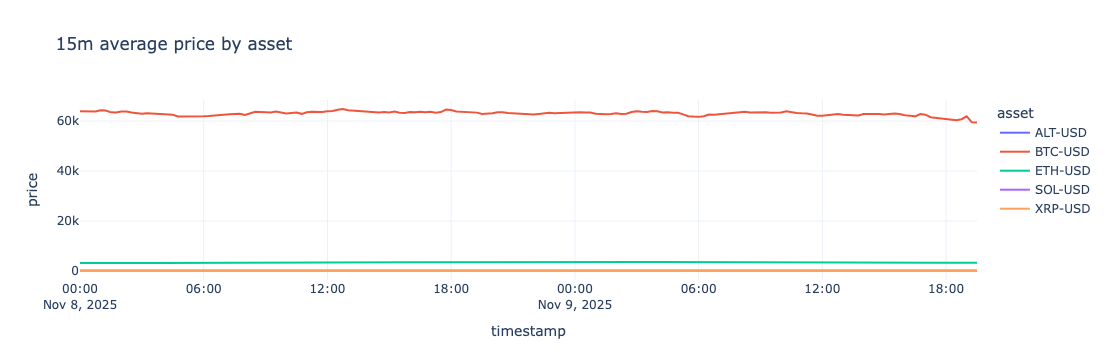

In [5]:
import plotly.express as px

price_series = trades.set_index('timestamp').groupby('asset')['price'].resample('15min').mean().dropna().reset_index()
fig = px.line(price_series, x='timestamp', y='price', color='asset', title='15m average price by asset')
fig.update_layout(template='plotly_white')
fig


### Aggressor Volume Leaders
Bar chart ranks the top initiator accounts by total notional traded. Large spikes vs peers can corroborate volume-spike or concentration alerts.

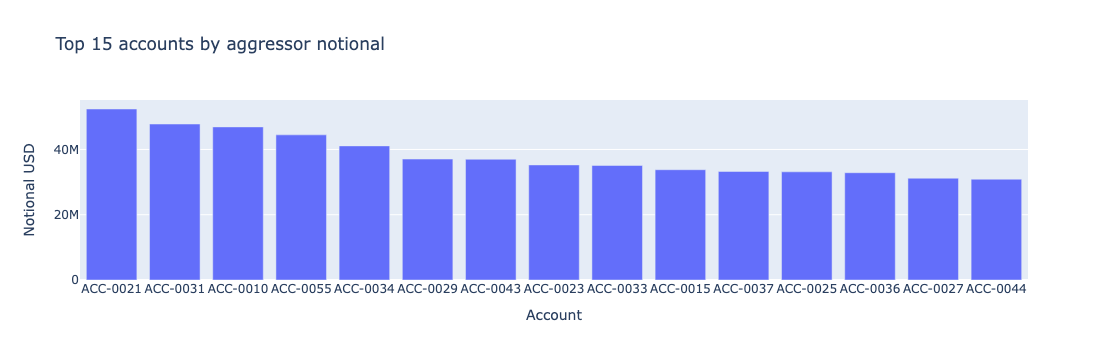

In [6]:
volume = trades.assign(notional=trades['price'] * trades['quantity'])
per_account = volume.groupby('initiator_account_id')['notional'].sum().nlargest(15).reset_index()
fig = px.bar(per_account, x='initiator_account_id', y='notional', title='Top 15 accounts by aggressor notional')
fig.update_layout(xaxis_title='Account', yaxis_title='Notional USD')
fig


### Order-Book Imbalance
Positive values indicate net visible buy liquidity; negative values show sell pressure. Watch for sudden flips that precede price swings or spoofing behavior.

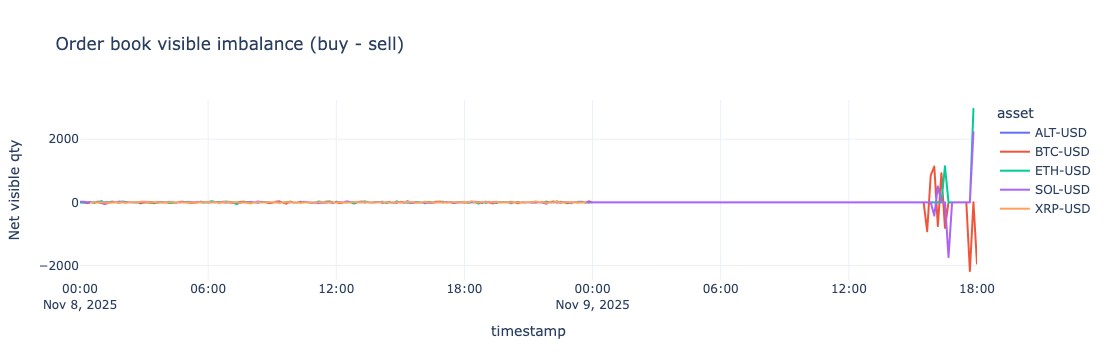

In [7]:
orders = orders.copy()
orders['timestamp'] = pd.to_datetime(orders['timestamp'])
orders['visible_quantity'] = orders['visible_quantity'].fillna(orders['quantity'])
orders['net_visible'] = orders['visible_quantity'].where(orders['side'].str.lower() == 'buy', -orders['visible_quantity'])
imbalance = (
    orders.set_index('timestamp')
    .groupby('asset')['net_visible']
    .resample('10min')
    .sum()
    .reset_index()
)
fig = px.line(imbalance, x='timestamp', y='net_visible', color='asset', title='Order book visible imbalance (buy - sell)')
fig.update_layout(template='plotly_white', yaxis_title='Net visible qty')
fig


### Cross-Venue Spread Plot
Each line shows `(max-min)/min` price spread for an asset sampled every 5 minutes. Elevated spikes highlight venue dislocations; flat lines mean venues are aligned.

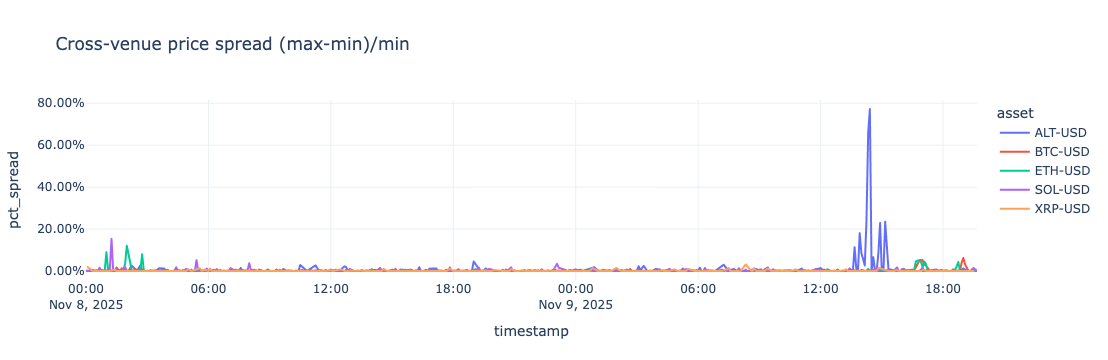

In [8]:
venue_prices = (
    trades.set_index('timestamp')
    .groupby(['asset', 'venue'])['price']
    .resample('5min')
    .mean()
    .dropna()
    .reset_index()
)
spread = (
    venue_prices.groupby(['asset', 'timestamp'])
    .agg(max_price=('price', 'max'), min_price=('price', 'min'))
    .reset_index()
)
spread['pct_spread'] = (spread['max_price'] - spread['min_price']) / spread['min_price']
fig = px.line(spread, x='timestamp', y='pct_spread', color='asset', title='Cross-venue price spread (max-min)/min')
fig.update_layout(template='plotly_white', yaxis_tickformat='.2%')
fig

### ML Anomaly Leaderboard
IsolationForest ingests engineered behavior features (venue concentration, cancel ratios, float share, shared infra sizes). Higher scores mean an account behaves unlike its peers. Review the table + bar chart to prioritize manual review; combine with rule alerts for context.

In [9]:
if ml_scores.empty:
    print('No ML scores available yet. Run the pipeline first.')
else:
    cols = ['account_id', 'detector', 'anomaly_score', 'float_share', 'total_notional', 'cancel_ratio', 'shared_ip_size', 'cluster_size']
    cols = [c for c in cols if c in ml_scores.columns]
    ml_top = (
        ml_scores.sort_values('anomaly_score', ascending=False)
        .groupby('detector')
        .head(5)
        .sort_values(['detector', 'anomaly_score'], ascending=[True, False])
    )
    display(ml_top[cols])
    fig = px.bar(
        ml_top,
        x='account_id',
        y='anomaly_score',
        color='detector',
        title='Top ML anomaly scores by detector',
        hover_data=[c for c in cols if c not in {'account_id', 'anomaly_score', 'detector'}]
    )
    fig.update_layout(template='plotly_white', xaxis_title='Account', yaxis_title='Score (higher = risk)')
    fig


,account_id,anomaly_score,float_share,total_notional,cancel_ratio,shared_ip_size
0,ACC-0021,0.102213,1.000000,5.239554e+07,0.380952,1
1,ACC-0049,0.065532,0.002628,2.261362e+07,2.636364,3
2,ACC-0035,0.055164,1.000000,2.739745e+07,0.833333,1
3,ACC-0019,0.018021,0.010955,2.196291e+07,4.187500,1
4,ACC-0003,0.000861,0.012567,1.514641e+07,0.333333,4
5,ACC-0028,-0.000335,0.018774,2.614215e+07,3.000000,1
6,ACC-0010,-0.003539,0.069334,4.690793e+07,0.500000,1
7,ACC-0018,-0.028675,0.012987,1.416279e+07,0.705882,3
8,ACC-0043,-0.049325,0.040714,3.699117e+07,0.866667,3
9,ACC-0004,-0.056156,0.012156,3.084319e+07,0.312500,3


### Case Management Panel
Use the dropdowns to filter alerts by severity or rule, select a specific alert id, then update status/notes. Sort order is newest first; use the notes field to capture analyst reasoning.

In [ ]:
import ipywidgets as widgets
from IPython.display import display

alerts['event_time'] = pd.to_datetime(
    alerts['event_time'], utc=True, format='ISO8601', errors='coerce'
)
alerts['severity'] = alerts['severity'].str.lower()
alerts['case_status'] = 'new'
case_notes = {}

severity_options = ['all'] + sorted(alerts['severity'].unique())
rule_options = ['all'] + sorted(alerts['rule_name'].unique())

severity_dd = widgets.Dropdown(options=severity_options, value='all', description='Severity')
rule_dd = widgets.Dropdown(options=rule_options, value='all', description='Rule')
alert_dd = widgets.Dropdown(options=[('Loading...', None)], description='Alert')
status_dd = widgets.Dropdown(options=['new', 'review', 'escalated', 'closed'], value='review', description='Set status')
note_area = widgets.Textarea(placeholder='Notes / actions / owner', description='Notes', layout=widgets.Layout(width='70%', height='80px'))
apply_btn = widgets.Button(description='Update case', button_style='success')
table_output = widgets.Output()
status_output = widgets.Output()

def build_alert_options(df):
    rows = []
    for _, row in df.head(50).iterrows():
        label = f"{int(row['alert_id'])} | {row['severity']} | {row['rule_name']} | {row.get('account_id', '-')}"
        rows.append((label, int(row['alert_id'])))
    if not rows:
        rows = [('No matching alerts', None)]
    return rows

def render_table(*_):
    df = alerts.copy()
    if severity_dd.value != 'all':
        df = df[df['severity'] == severity_dd.value]
    if rule_dd.value != 'all':
        df = df[df['rule_name'] == rule_dd.value]
    with table_output:
        table_output.clear_output()
        cols = ['event_time', 'severity', 'rule_name', 'account_id', 'case_status', 'related_accounts', 'description']
        display(df.sort_values('event_time', ascending=False)[cols].head(30))
    alert_dd.options = build_alert_options(df)

def apply_update(_):
    if alert_dd.value is None:
        return
    idx = alert_dd.value
    alerts.loc[alerts['alert_id'] == idx, 'case_status'] = status_dd.value
    case_notes[idx] = note_area.value.strip()
    with status_output:
        status_output.clear_output()
        note_hint = ' (note saved)' if case_notes[idx] else ''
        print(f"Alert {idx} updated to {status_dd.value}{note_hint}.")
    render_table()

apply_btn.on_click(apply_update)
severity_dd.observe(render_table, names='value')
rule_dd.observe(render_table, names='value')

controls = widgets.VBox([
    widgets.HBox([severity_dd, rule_dd]),
    widgets.HBox([alert_dd, status_dd]),
    note_area,
    apply_btn,
])

display(controls, table_output, status_output)
render_table()


### Alert Reference Cheat Sheet
- **Severity levels**: `high` = immediate escalation, `medium` = analyst follow-up, `low` = context only.
- **Case statuses**: start at `new`, move to `review` during analysis, mark `escalated` for hand-off, and `closed` once dispositioned.
- **Key rule hints**:
  - `network_collusion` → shared IP/device; correlate with cluster table.
  - `ml_behavioral_anomaly` → high IsolationForest score; inspect ML leaderboard features.
  - `cross_market_divergence` → check venue spread plot for same timestamp.
Use these cues while taking notes in the panel so reviewers understand the story quickly.